In [1]:
import gym
import numpy as np
import torch
import torch.nn as nn 
import torch.nn.functional as F

import sys
# insert at 1, 0 is the script path (or '' in REPL)
sys.path.insert(1, '../Envs/gym-grid/gym_grid/envs/')

import gridworld as GW
from importlib import reload

import matplotlib.pyplot as plt

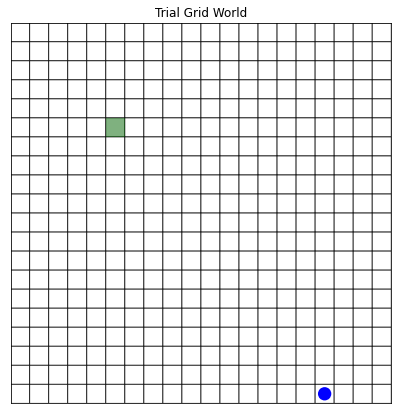

In [2]:
reload(GW)
env = GW.GridWorld4()
#env = gym.make('gym_grid:gridworld-v1')
data_col = [[],[],[]]

# check functions of gridworld gym env
env.reset()

def get_action(s):
    return np.random.choice(len(env.action_list))

In [4]:
def get_samples(maxsteps):
    data_col = [[],[],[]]

    for step in range(maxsteps):
        s = env.get_state()
        state = env.get_observation()


        action = get_action(s)

        s_prime, r, done, __ = env.step(action)
        next_state = env.get_observation()

        data_col[0].append(state*10)
        data_col[1].append(action)
        data_col[2].append(next_state*10)

        #env.render(0.05)

        if step == maxsteps-1 or done:
            #plt.show(block=True)
            pass

        if done:
            env.reset()
            #break
    return data_col

class SRNet(nn.Module):
    def __init__(self):
        super(SRNet, self).__init__()
        
        self.rep_layer_dims = 400
        hidden_units_sr=(self.rep_layer_dims*4,)
        in_channels = 3
        
        self.conv1 = nn.Conv2d(in_channels, 32, kernel_size=4, stride=2)
        self.conv2 = nn.Conv2d(32, 32, kernel_size=4, stride=1)
        self.conv3 = nn.Conv2d(32, 32, kernel_size=2, stride=1)
        self.rep   = nn.Linear(5*5*32,self.rep_layer_dims)
        
        self.lin1  = nn.Linear(self.rep_layer_dims, 5*5*32)
        self.dconv1= nn.ConvTranspose2d(32,32, kernel_size=2, stride=1)
        self.dconv2= nn.ConvTranspose2d(32,32, kernel_size=4, stride=1)
        self.dconv3= nn.ConvTranspose2d(32,in_channels, kernel_size=4, stride=2)
        
        
        self.sr    = nn.Linear(self.rep_layer_dims, self.rep_layer_dims)
        
    def forward(self, state, action):
        action = torch.unsqueeze(torch.Tensor(action),1)
        x = torch.Tensor(state)
        batch_size = x.shape[0]
        
        # encode
        x = F.relu(self.conv1(x))
        
        x = F.relu(self.conv2(x))
        
        x = F.relu(self.conv3(x))
        
        
        # cast x into correct shape
        x = x.view(batch_size,32*5*5)
        
        
        # get latent representation
        phi = F.relu(self.rep(x))
        
        # get SR
        psi = F.relu(self.sr(phi)) ## no relu 
        
        x = torch.cat((phi, action), 1)
        x = F.relu(self.lin1(phi))
        
        # cast x into correct shape 
        x = x.view(batch_size, 32, 5, 5)
        
        # decode
        x = F.relu(self.dconv1(x))
        
        x = F.relu(self.dconv2(x))
        
        reconstruct = F.relu(self.dconv3(x))
        
        return phi, psi, reconstruct

In [5]:
def plot_phi(phi):
    data = phi[0].detach().numpy()
    print(data.shape)
    plt.imshow(data, aspect='auto')
    plt.show()

In [6]:
testsr = SRNet()
loss = nn.MSELoss(reduction='mean')
#print(testsr)
loss_tracker = []


(1, 400)


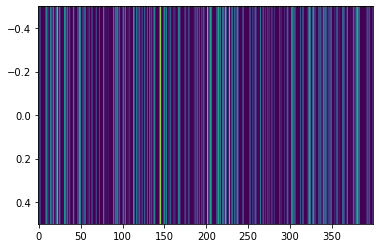

/home/annik/.local/lib/python3.8/site-packages/torch/autograd/__init__.py:130: UserWarning: CUDA initialization: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx (Triggered internally at  /pytorch/c10/cuda/CUDAFunctions.cpp:100.)
  Variable._execution_engine.run_backward(


Training Cycle:0 Loss:0.16784171760082245
Training Cycle:1 Loss:0.1676836907863617
Training Cycle:2 Loss:0.1674201339483261
Training Cycle:3 Loss:0.16725227236747742
Training Cycle:4 Loss:0.16700336337089539
Training Cycle:5 Loss:0.16688382625579834
Training Cycle:6 Loss:0.16683104634284973
Training Cycle:7 Loss:0.16669771075248718
Training Cycle:8 Loss:0.16682855784893036
Training Cycle:9 Loss:0.1659303605556488
Training Cycle:10 Loss:0.16441340744495392
Training Cycle:11 Loss:0.16162896156311035
Training Cycle:12 Loss:0.1572999209165573
Training Cycle:13 Loss:0.15014208853244781
Training Cycle:14 Loss:0.14168857038021088
Training Cycle:15 Loss:0.1302669495344162
Training Cycle:16 Loss:0.11931036412715912
Training Cycle:17 Loss:0.10967501252889633
Training Cycle:18 Loss:0.09885303676128387
Training Cycle:19 Loss:0.09265509247779846
Training Cycle:20 Loss:0.08881160616874695
Training Cycle:21 Loss:0.08669687062501907
Training Cycle:22 Loss:0.08611464500427246
Training Cycle:23 Loss:0.0

Training Cycle:190 Loss:0.08322122693061829
Training Cycle:191 Loss:0.08328019827604294
Training Cycle:192 Loss:0.08333657681941986
Training Cycle:193 Loss:0.08337095379829407
Training Cycle:194 Loss:0.08337362855672836
Training Cycle:195 Loss:0.08335472643375397
Training Cycle:196 Loss:0.08329428732395172
Training Cycle:197 Loss:0.0833236426115036
Training Cycle:198 Loss:0.08338513970375061
Training Cycle:199 Loss:0.08322006464004517
Training Cycle:200 Loss:0.08334910124540329
Training Cycle:201 Loss:0.08315712213516235
Training Cycle:202 Loss:0.08328733593225479
Training Cycle:203 Loss:0.08322803676128387
Training Cycle:204 Loss:0.08325652033090591
Training Cycle:205 Loss:0.08336131274700165
Training Cycle:206 Loss:0.08337508141994476
Training Cycle:207 Loss:0.08334379643201828
Training Cycle:208 Loss:0.0833403617143631
Training Cycle:209 Loss:0.08326905965805054
Training Cycle:210 Loss:0.08330743759870529
Training Cycle:211 Loss:0.08338577300310135
Training Cycle:212 Loss:0.08326071

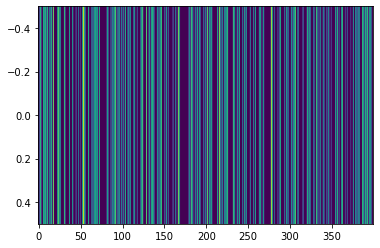

In [7]:
optimizer = torch.optim.Adam(testsr.parameters(), lr = 0.001)
training_cycles = 250

s = np.expand_dims(env.get_observation(agtlocation=(5,5)), axis=0)
p = testsr(s,[0])
plot_phi(p)

for train in range(training_cycles):
    
    # get samples from env
    [states, actions, n_states] = get_samples(1000)
    # get guesses from network 
    phi, psi, reconst = testsr(states, actions)

    # compute loss
    optimizer.zero_grad()
    output = loss(reconst, torch.Tensor(n_states))
    loss_tracker.append(output)
    output.backward()
    optimizer.step()
    
    print(f'Training Cycle:{train} Loss:{output}')
    
p = testsr(s,[0])
plot_phi(p)

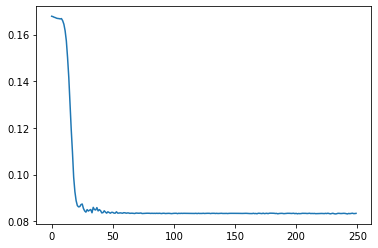

In [8]:
plt.plot(loss_tracker)

In [9]:
def plot_frames(obsr):
    obs = obsr[0]
    fig, ax = plt.subplots(1,3, sharey = True)
    print(obs[0].shape)
    cmap = 'bone_r'
    ax[0].pcolor(obs[0],cmap=cmap)
    ax[0].set_title('Grid')
    ax[1].pcolor(obs[1],cmap=cmap)
    ax[1].set_title('Reward')
    ax[2].pcolor(obs[2],cmap=cmap)
    ax[2].set_title('Agent')
    for i in range(3):
        ax[i].invert_yaxis()
        ax[i].set_aspect('equal')
    
    plt.show()

(20, 20)


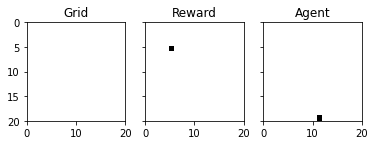

(20, 20)


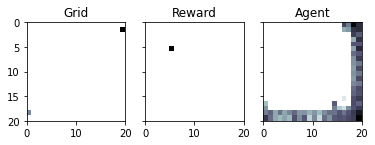

In [10]:
def plot_state(state):
    if state.detach().numpy().shape[0] == 1:
        numpy_state = state.detach().numpy()[0]
    else:
        numpy_state = state.detach().numpy()
        
    print(numpy_state.shape)
    grid = numpy_state[0]
    reward_loc = numpy_state[1]
    agent_loc = numpy_state[2]
    r_r, r_c = np.where(reward_loc==1)
    
    print(reward_loc)
    #plot_world(env, numpy_state, scale=0.3)
    
    
    
test_s, test_a, test_sprime = get_samples(1)
phi, psi, test_reconst = testsr(test_s, [0])

x = torch.Tensor(test_sprime)
y = test_reconst

plot_frames(test_sprime)
plot_frames(test_reconst.detach().numpy())
